# Task 3. Clustering

**Изучите на скрытые темы “Преступление и наказание”**

1. Реализуйте тематическое моделирование через кластеризацию и BERTopic
2. Сравните эффективность использования евклидова расстояния и 2 других типов расстояния в кластеризации
3. Визуализируйте кластера по выделенным топикам
4. Выложите на github

## Imports

In [ ]:
!pip install pymorphy2

In [ ]:
!pip install bertopic
!pip install sentence_transformers

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize, sent_tokenize, download
from nltk.corpus import stopwords
from tqdm import tqdm
import pymorphy2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

download('punkt')
download('stopwords')
stop_words = stopwords.words('russian') + ['это', 'сам', 'ты', 'ваш', 'мой', 'этот', 'всё', 'весь', 'очень', 'который', 'самый', 'ещё', 'свой']

from pymorphy2 import MorphAnalyzer
morph = pymorphy2.MorphAnalyzer()
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Breaking the book text into parts

In [4]:
with open('Crime And Punishment.txt', encoding='utf-8') as file:
    text = file.readlines()

# text = [line.strip() for line in text]
# text = ' '.join(text)

In [5]:
text[:25]

['Annotation\n',
 '\n',
 '\n',
 '«Преступление и наказание» – гениальный роман, главные темы которого: преступление и наказание, жертвенность и любовь, свобода и гордость человека – обрамлены почти детективным сюжетом.\n',
 '\n',
 'Многократно экранизированный и не раз поставленный на сцене, он и по сей день читается на одном дыхании.\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '* * *\n',
 '\n',
 '\n',
 '\n',
 'Часть первая\n',
 'I\n',
 '\n',
 'II\n',
 '\n',
 'III\n',
 '\n',
 'IV\n',
 '\n',
 'V\n']

Для начала я решаю разделить текст на части - всего их в книге 6

In [6]:
parts = parts = ' '.join([line.strip() for line in text])
parts = re.split(r'Часть\s+\w+', parts)

In [7]:
for part in parts:
    print(len(part))

319
33
33
28
28
25
445
173560
202796
162369
155077
155889
225388


In [8]:
parts = parts[7:]
# отсеиваю первые элементы списка, поскольку они состоят из оглавления и аннтоации и нерелевантны

Далее каждую часть разделяю на отдельные главы

In [9]:
chapters = []

for part in parts:
    part_chapters = re.split(r'\b[IV]+\b', part)
    chapters.extend([chapter.strip() for chapter in part_chapters if chapter.strip()])

In [10]:
len(chapters)

41

In [11]:
for i in chapters:
    print(len(i))

16487
35024
27284
25241
20847
25478
23103
34455
21781
27265
21178
22703
38831
36487
26917
24001
26941
22792
39402
22234
26047
24747
16057
31773
41372
14999
36517
29014
30392
33087
26810
19960
28931
20013
23940
29030
29090
18170
20500
18168
17457


Поскольку главы получатся довольно объемными, я решаю еще сильнее фрагментировать текст и делю его на абзацы

In [5]:
with open('Crime And Punishment.txt', encoding='utf-8') as file:
    text2 = file.read()

paragraphs = text2.split('\n\n')
paragraphs = [p.strip() for p in paragraphs if p.strip()]
len(paragraphs)

3969

In [13]:
print(sum(1 for i in paragraphs if len(i) <= 25))

555


## Предобработка

In [6]:
## главы

def clean_text(text):
    text = re.sub(r'[^а-яё]', ' ', text, flags=re.IGNORECASE).lower()
    text = word_tokenize(text)

    lemmatized_text = list()

    for word in text:
        result = morph.parse(word)
        most_probable_res = result[0]
        lemmatized_text.append(most_probable_res.normal_form)

    text = [word for word in lemmatized_text if word not in stop_words and len(word) > 2]

    return ' '.join(text)

In [15]:
cleaned_chapters = [clean_text(chapter) for chapter in tqdm(chapters)]

100%|██████████| 41/41 [02:10<00:00,  3.19s/it]


In [7]:
## параграфы

cleaned_paragraphs = [clean_text(paragraph) for paragraph in tqdm(paragraphs) if paragraph.strip()]

100%|██████████| 3969/3969 [01:24<00:00, 47.18it/s]


In [17]:
words = ' '.join(cleaned_paragraphs)
words = words.split()

word_counts = Counter(words)
most_common_words = word_counts.most_common(30)
print(*most_common_words, sep='\n')

('мочь', 796)
('знать', 630)
('раскольник', 567)
('сказать', 544)
('говорить', 535)
('человек', 501)
('стать', 438)
('соня', 379)
('рука', 369)
('петрович', 369)
('нибыть', 364)
('дело', 363)
('разумихин', 353)
('хотеть', 338)
('иванович', 338)
('минута', 278)
('видеть', 276)
('смотреть', 264)
('время', 261)
('пойти', 261)
('слово', 237)
('думать', 233)
('лицо', 231)
('глаз', 230)
('дверь', 224)
('казаться', 224)
('катерина', 223)
('комната', 211)
('голова', 211)
('прийти', 208)


In [18]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.util import bigrams


words = ' '.join(cleaned_paragraphs)
# words = words.split()

tokens = word_tokenize(words)
bigram_freq = Counter(list(bigrams(tokens)))

for bigram, freq in bigram_freq.most_common(10):
    print(f'Bigram: {bigram}, Frequency: {freq}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Bigram: ('катерина', 'иванович'), Frequency: 223
Bigram: ('пётр', 'петрович'), Frequency: 179
Bigram: ('пульхерия', 'александрович'), Frequency: 127
Bigram: ('авдотья', 'романович'), Frequency: 118
Bigram: ('порфирий', 'петрович'), Frequency: 79
Bigram: ('марфа', 'петрович'), Frequency: 78
Bigram: ('софья', 'семёнович'), Frequency: 75
Bigram: ('крайний', 'мера'), Frequency: 61
Bigram: ('амалия', 'иванович'), Frequency: 56
Bigram: ('сей', 'пора'), Frequency: 51


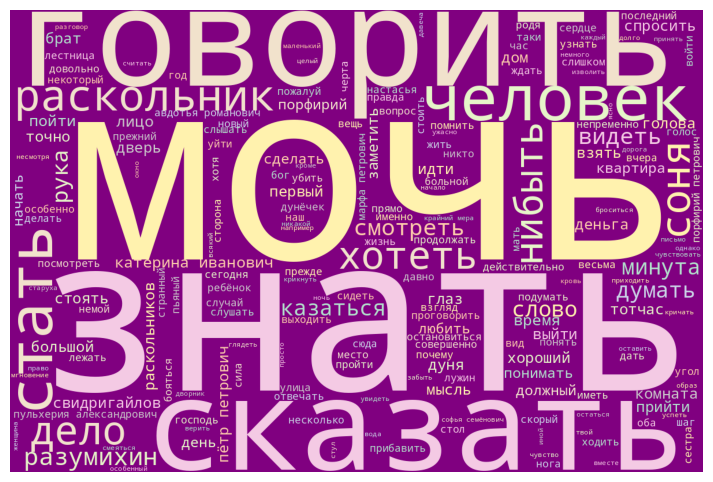

In [19]:
wordcloud = WordCloud(width=1200,
                      height=800,
                      background_color='purple',
                      colormap='Pastel2').generate(' '.join(cleaned_paragraphs))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Topic modeling

In [20]:
len(cleaned_paragraphs)

3969

In [21]:
print(sum(1 for i in cleaned_paragraphs if len(i)==0))

246


Чищу список сначала от пустых абзацев, а затем от слишком коротких (меньше 7 токенов), в результате чего количество абзацев значительно сокращается

In [8]:
cleaned_paragraphs = [paragraph for paragraph in cleaned_paragraphs if len(paragraph) > 0]

In [9]:
len(cleaned_paragraphs)

3723

In [10]:
for paragraph in cleaned_paragraphs[:5]:
    print(paragraph)

преступление наказание гениальный роман главный тема преступление наказание жертвенность любовь свобода гордость человек обрамить детективный сюжет
многократно экранизировать поставить сцена сей день читаться дыхание
часть первый
часть второй
часть третий


In [11]:
cleaned_paragraphs = [paragraph for paragraph in cleaned_paragraphs if len(paragraph.split()) >= 7]

In [12]:
len(cleaned_paragraphs)

2309

In [27]:
for paragraph in cleaned_paragraphs[:5]:
    print(paragraph)

print(f"Type of cleaned_paragraphs: {type(cleaned_paragraphs)}")
print(f"Type of first element: {type(cleaned_paragraphs[0])}")

преступление наказание гениальный роман главный тема преступление наказание жертвенность любовь свобода гордость человек обрамить детективный сюжет
многократно экранизировать поставить сцена сей день читаться дыхание
начало июль чрезвычайно жаркое время вечер молодой человек выйти каморка нанимать жилец переулок улица медленно нерешимость отправиться мост
благополучно избегнуть встреча хозяйка лестница каморка приходиться кровля высокий пятиэтажный дом походить шкаф квартира квартирный хозяйка нанимать каморка обед прислуга помещаться лестница ниже отдельный квартира каждый выход улица непременно проходить мимо хозяйкин кухня настежь отворить лестница каждый молодой человек проходить мимо чувствовать болезненный трусливый ощущение стыдиться морщиться должный кругом хозяйка бояться встретиться
трусливый забитый напротив некоторый время раздражительный напрячь состояние похожий ипохондрия углубиться уединиться бояться всякий встреча встреча хозяйка задавить бедность стеснённый положение 

Векторизация, обучение модели (я выделяю не только отдельные слова, но и биграмы)

In [13]:
vectorizer_model = TfidfVectorizer(ngram_range=(1, 2), min_df=2, stop_words=None)
X = vectorizer_model.fit_transform(cleaned_paragraphs)

vocab = vectorizer_model.get_feature_names_out()
print(f"Vocabulary size: {len(vocab)}")

print(f"Sample vocabulary: {vocab[:10]}")

Vocabulary size: 10706
Sample vocabulary: ['авдотья' 'авдотья романович' 'авось' 'автор' 'авторитет' 'адвокат'
 'адвокатский' 'административный' 'административный центр' 'адрес']


In [14]:
vectorizer_model = TfidfVectorizer(ngram_range=(1, 2), min_df=2, stop_words=None)

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='russian',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(cleaned_paragraphs)

2024-07-31 21:32:52,668 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

2024-07-31 21:35:39,671 - BERTopic - Embedding - Completed ✓
2024-07-31 21:35:39,674 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-31 21:36:01,089 - BERTopic - Dimensionality - Completed ✓
2024-07-31 21:36:01,091 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-31 21:36:01,445 - BERTopic - Cluster - Completed ✓
2024-07-31 21:36:01,457 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-31 21:36:01,767 - BERTopic - Representation - Completed ✓


In [15]:
print(model.get_topic_info())

    Topic  Count                                               Name  \
0      -1    856                   -1_мочь_семёнович_знать_петрович   
1       0    246          0_иванович_год_катерина_катерина иванович   
2       1    178                       1_бог_господь_лизавета_иисус   
3       2    152  2_пётр_пётр петрович_петрович_пульхерия алекса...   
4       3     97                     3_дверь_лестница_этаж_квартира   
5       4     91                           4_лицо_бледный_глаз_губа   
6       5     85                 5_сестра_мать_маменька_мать сестра   
7       6     63                    6_факт_верить_весьма_привидение   
8       7     42                   7_диван_сесть диван_порог_встать   
9       8     41         8_преступление_преступник_убийство_убежать   
10      9     41                9_проговорить_разговор_шиллер_тихий   
11     10     32  10_разумихин_нахмуриться_неужели видеть_закладчик   
12     11     30        11_брат_романович_авдотья_авдотья романович   
13    

In [16]:
print(model.get_topic(0))

[('иванович', 0.011695379669686168), ('год', 0.009711539065700745), ('катерина', 0.008902438459806906), ('катерина иванович', 0.008902438459806906), ('мочь', 0.008682207237490623), ('человек', 0.007940560850833507), ('амалия', 0.007895656724736131), ('петрович', 0.007570304290908019), ('жизнь', 0.007413867571395679), ('марфа петрович', 0.007404727314382975)]


In [17]:
for topic_id in model.get_topic_info().Topic:
    if topic_id == -1:
        continue
    print(f"Topic {topic_id}:")
    print(model.get_topic(topic_id))

Topic 0:
[('иванович', 0.011695379669686168), ('год', 0.009711539065700745), ('катерина', 0.008902438459806906), ('катерина иванович', 0.008902438459806906), ('мочь', 0.008682207237490623), ('человек', 0.007940560850833507), ('амалия', 0.007895656724736131), ('петрович', 0.007570304290908019), ('жизнь', 0.007413867571395679), ('марфа петрович', 0.007404727314382975)]
Topic 1:
[('бог', 0.03401760052751148), ('господь', 0.024603030079706743), ('лизавета', 0.01900965953984257), ('иисус', 0.01867865792899252), ('любить', 0.014810498494346427), ('прощать', 0.014645076070552522), ('жизнь', 0.014643568160263225), ('сказать', 0.013301817978153512), ('убить', 0.013041906988379922), ('умереть', 0.012839131452031657)]
Topic 2:
[('пётр', 0.06730119091286126), ('пётр петрович', 0.06730119091286126), ('петрович', 0.06501198989516208), ('пульхерия александрович', 0.03697312362819356), ('пульхерия', 0.03697312362819356), ('александрович', 0.03697312362819356), ('семёнович', 0.01989594993774754), ('пор

## Visualization


In [18]:
fig = model.visualize_topics()
fig.show()

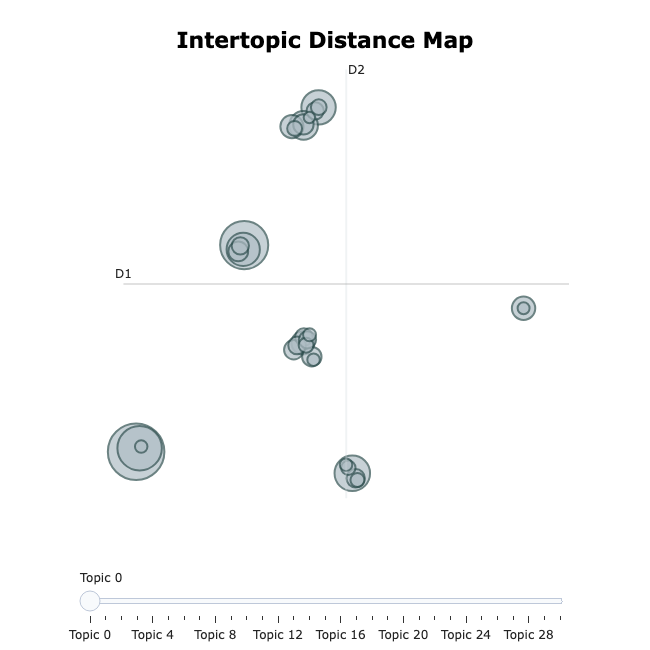

In [23]:
fig = model.visualize_barchart(top_n_topics=30)
fig.show()

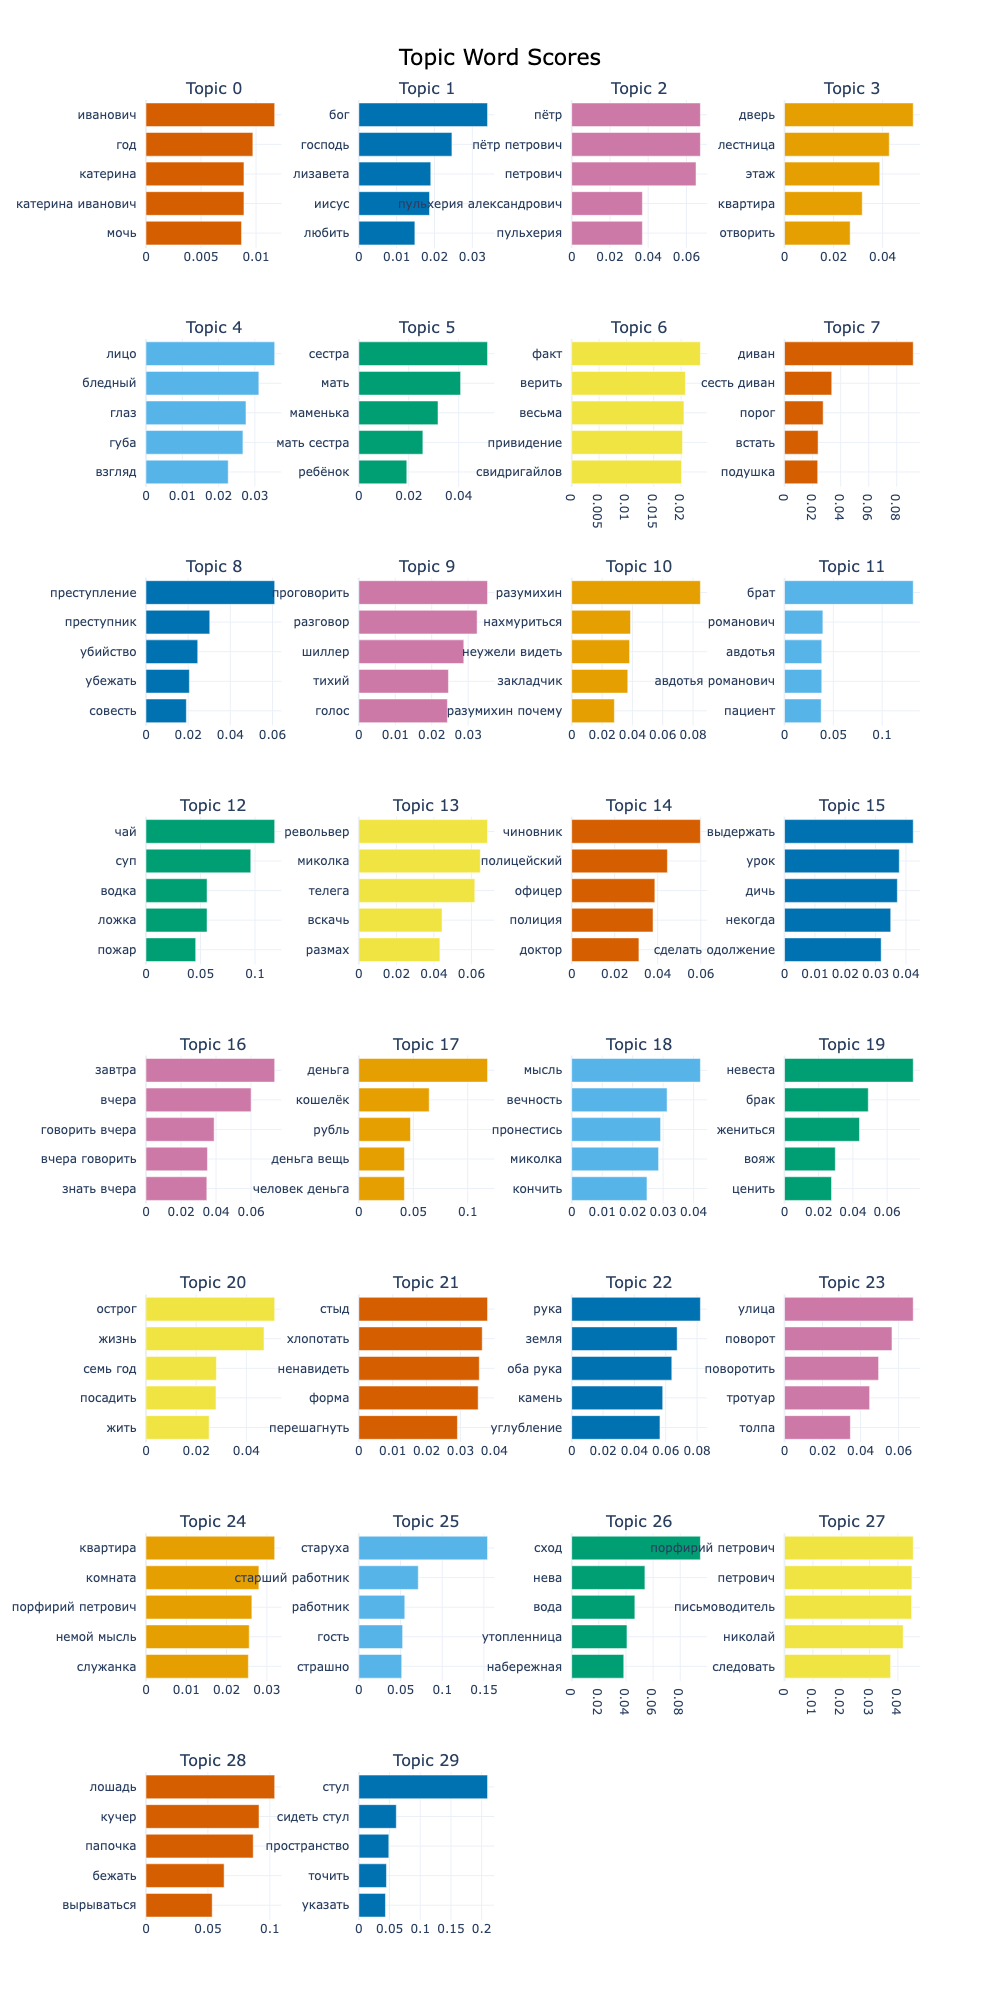

В целом темы получились более или менее осмысленные - по ним можно заметить, что в тексте поднимаются различные социальные, нравственные, философские проблемы, такие как: моральные и этические аспекты преступления (Topic 21); вина и раскаяние (Topic 18, 21); социальное неравенство и бедственное положение широких слоев общества, Петербург, быт его населения (Topic 12, 26); любовь и самопожертвование, семья (Topic 1, 5, 7, 19); правосудие и наказание (Topic 14, 20); религия и духовное возрождение (Topic 1) и т.д.

На interoptic distance map видны четко оформленные кластеры, находящиеся на значительном расстоянии друг от друга, однако внутри четко оформленных групп многие кластеры наслаиваются дргу на друга

In [25]:
model.visualize_heatmap()

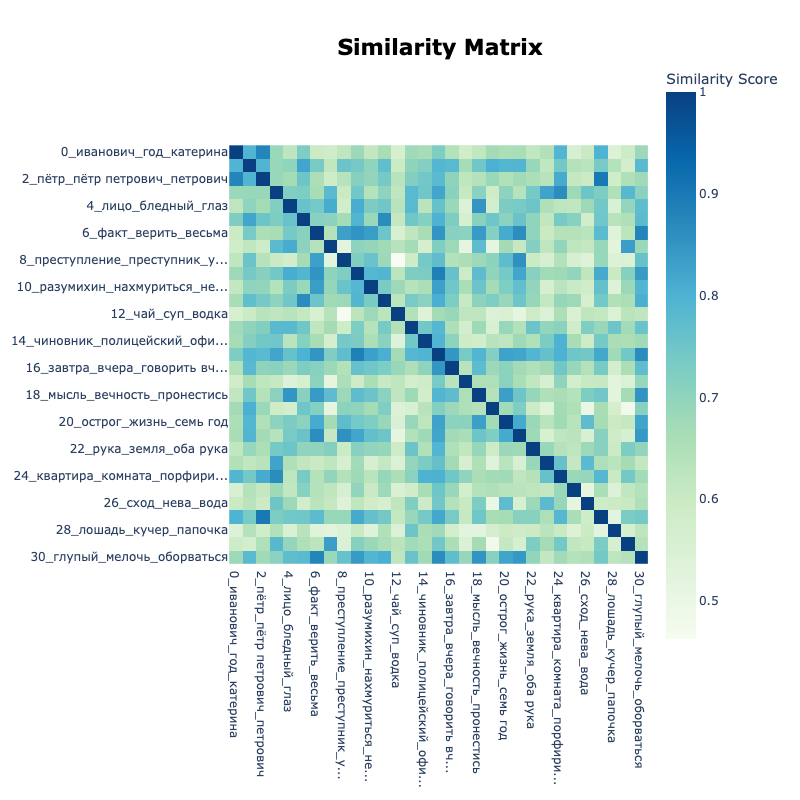

## Сравнение эффективности использования различных типов расстояния

BERTopic с эмбеддингом

In [ ]:
!pip install sentence-transformers

In [36]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap
from umap import UMAP

In [ ]:
sentence_model = SentenceTransformer("sentence-transformers/paraphrase-xlm-r-multilingual-v1")
embeddings = sentence_model.encode(cleaned_paragraphs, show_progress_bar=True)

topic_model = BERTopic(language='russian')
topics, probs = topic_model.fit_transform(cleaned_paragraphs, embeddings)

In [ ]:
def evaluate_clustering(embeddings, labels):
    metrics = {}

    metrics['Silhouette Score'] = silhouette_score(embeddings, labels)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(embeddings, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(embeddings, labels)

    return metrics

In [ ]:
reduced_embeddings_euclidean = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='euclidean').fit_transform(embeddings)
euclidean_metrics = evaluate_clustering(reduced_embeddings_euclidean, topics)

reduced_embeddings_cosine = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
cosine_metrics = evaluate_clustering(reduced_embeddings_cosine, topics)

reduced_embeddings_manhattan = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='manhattan').fit_transform(embeddings)
manhattan_metrics = evaluate_clustering(reduced_embeddings_manhattan, topics)

In [48]:
print("Euclidean Distance Metrics:", euclidean_metrics)
print("Cosine Distance Metrics:", cosine_metrics)
print("Manhattan Distance Metrics:", manhattan_metrics)

Euclidean Distance Metrics: {'Silhouette Score': 0.6398835, 'Davies-Bouldin Index': 0.32136005753866403, 'Calinski-Harabasz Index': 5941.942853932856}
Cosine Distance Metrics: {'Silhouette Score': 0.6209054, 'Davies-Bouldin Index': 0.297983556099613, 'Calinski-Harabasz Index': 6817.72765602949}
Manhattan Distance Metrics: {'Silhouette Score': 0.5974507, 'Davies-Bouldin Index': 0.33058593246061624, 'Calinski-Harabasz Index': 5927.606672013937}


с уетом общего баланса метрик можно выбрать косинусное расстояние как наиболее подходящее